In this tutorial, you will learn how to use snnTorch to:
- convert datasets into spiking datasets,
- how to visualise them,
- and how to generate random spike trains.

# Mã hóa dữ liệu bằng Spike

Con người cảm nhận thế giới bằng **xung điện (spikes)**:

- Ánh sáng: Photon → Spike (võng mạc)
- Mùi: Phân tử bay hơi → Spike (mũi)
- Xúc giác: Áp lực → Spike (dây thần kinh)

 **Não bộ hoạt động dựa trên ngôn ngữ của spike**.

---

## Tại sao nên dùng spike làm đầu vào cho mạng SNN?

Mặc dù có thể dùng đầu vào liên tục (non-spiking), nhưng dùng spike có 3 lợi ích lớn (gọi là 3 chữ S):

### 1. Spikes
- Nơ-ron sinh học truyền tín hiệu bằng xung điện (~100 mV).
- Trong mô hình hoá, spike được biểu diễn đơn giản dưới dạng bit: `'1'` hoặc `'0'`.
- Điều này giúp dễ dàng biểu diễn trên phần cứng và giảm chi phí tính toán.

### 2. Sparsity (Thưa thớt)
- Hầu hết nơ-ron nghỉ ngơi → nhiều giá trị kích hoạt là `0`.
- Tiết kiệm bộ nhớ và tăng tốc tính toán vì nhiều phép nhân có thể **bỏ qua (×0)**.
- Rất phù hợp với phần cứng neuromorphic.

### 3. Static Suppression (Xử lý theo sự kiện)
- Chỉ xử lý khi có thay đổi đầu vào.
- Ví dụ: pixel chỉ phản ứng khi ánh sáng thay đổi → phần ảnh không đổi sẽ **bị bỏ qua**.
- Giảm đáng kể lượng dữ liệu xử lý → **tiết kiệm năng lượng** và **tăng tốc**.

---

📍 **Kết luận:** Nếu đã xây dựng SNN thì nên dùng đầu vào dạng spike để đồng bộ với cách mà não bộ xử lý tín hiệu — hiệu quả hơn, tự nhiên hơn, và tối ưu hơn cho phần cứng.
![Sơ đồ spike](p_spike_diagram.png)

In [1]:
import snntorch as snn
import torch 

In [2]:
#training paramter
batch_size = 128
data_path = '../tmp/data/mnist'
num_classes = 10 #MNIST has 10 output classes

#torch variable
dtype = torch.float

# Download dataset

In [3]:
from torchvision import datasets, transforms

#define transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform = transform)

Until we actually start training a network, we won’t need large datasets. snntorch.utils contains a few useful functions for modifying datasets. Apply data_subset to reduce the dataset by the factor defined in subset. E.g., for subset=10, a training set of 60,000 will be reduced to 6,000.

In [4]:
from snntorch import utils

subnet = 10

mnist_train = utils.data_subset(mnist_train, subnet)

print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size batch_size.

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# ⚡ 2. Mã hóa dữ liệu bằng Spike (Spike Encoding)

SNN được thiết kế cho dữ liệu **có tính thời gian**, nhưng MNIST là **dữ liệu tĩnh**. Có 2 cách sử dụng MNIST với SNN:

---

## Cách 1: Static Input (ảnh giữ nguyên)

- Ảnh được lặp lại tại **mỗi bước thời gian**
- Mỗi pixel nhận giá trị chuẩn hóa `[0, 1]`
- Không khai thác được đặc điểm thời gian của SNN

![Static Input](https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true)

---

## Cách 2: Spike Train (ảnh biến thành chuỗi xung)

- Mỗi pixel → chuỗi spike độ dài `num_steps`
- Tạo dữ liệu **thay đổi theo thời gian**, phản ánh ảnh gốc

![Spike Input](https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true)

---

## 🛠️ Các phương pháp mã hóa spike trong `snntorch.spikegen`

| Phương pháp | Cách hoạt động |
|-------------|----------------|
| `rate` | Dựa vào giá trị đầu vào để quyết định **tần suất xung** |
| `latency` | Dựa vào giá trị đầu vào để quyết định **thời điểm xung** |
| `delta` | Dựa vào **mức thay đổi** theo thời gian để tạo xung |

---

📌 **Gợi ý:** Nếu muốn tận dụng sức mạnh của SNN, nên dùng spike train thay vì ảnh tĩnh.


## 2.1 Mã hóa tốc độ (Rate Coding) cho MNIST

Mỗi đặc trưng đầu vào đã chuẩn hóa `x ∈ [0,1]` được dùng làm **xác suất để phát ra một xung** tại mỗi bước thời gian.

- Đây là một phép **thử Bernoulli**:
  - Số lần thử: `num_steps`
  - Xác suất thành công: `x`
  - Kết quả: dãy nhị phân gồm `0` và `1`, đại diện cho **spike/no-spike**

> 📌 **Xác suất phát ra xung tại một bước thời gian:**  
![xác xuất](p_rate_coding.png)

Create a vector filled with the value ‘0.5’ and encode it using the above technique:

In [6]:
# temporal dynamics
num_steps = 10

#create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

#pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)

In [7]:
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
The output is spiking 40.00% of the time.


In [8]:
num_steps = 100

#create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

#pass each sample throuh a Bernoulli traial 
rate_coded_vector = torch.bernoulli(raw_vector)

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 45.00% of the time.


## Tỷ lệ xung tiệm cận giá trị gốc (`num_steps`)

Khi **số bước thời gian `num_steps` tăng**, tỷ lệ xung sinh ra sẽ **gần đúng với giá trị ban đầu của dữ liệu**.

- Với ảnh MNIST, mỗi giá trị pixel trong khoảng `[0.0, 1.0]` được coi là **xác suất phát ra spike**
  - Pixel trắng (`1.0`) → 100% phát ra spike
  - Pixel đen (`0.0`) → không bao giờ phát ra spike

 **Minh họa trực quan (cột Rate Coding):**  
![Rate Coding Visualization](https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true)

---

In a similar way, spikegen.rate can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use num_steps to repeat it across time.

In [9]:
from snntorch import spikegen

#interate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

#spiking data
spike_data = spikegen.rate(data_it, num_steps = num_steps)

In [10]:
spike_data.size()

torch.Size([100, 128, 1, 28, 28])

2.2 Visualization

In [11]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

To plot one sample of data, index into a single sample from the batch (B) dimension of spike_data, [T x B x 1 x 28 x 28]

In [12]:
spike_data_sample = spike_data[:, 0,0]  # chọn ảnh đầu tiên trong batch
print(spike_data_sample.size())
torch.Size([100, 28, 28])

torch.Size([100, 28, 28])


torch.Size([100, 28, 28])

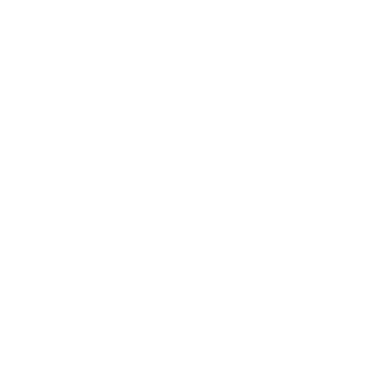

In [13]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'
HTML(anim.to_html5_video())

In [14]:
anim.save("spike_mnist_test.mp4")

In [15]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 7


## Điều chỉnh tần suất phát xung với `gain`

Ảnh MNIST là ảnh **grayscale (mức xám)**, trong đó các pixel trắng (giá trị = 1.0) tương ứng với xác suất **100% phát xung** ở mỗi bước thời gian.

> Điều này có nghĩa là văn bản màu trắng trong ảnh MNIST luôn luôn phát ra xung ở mỗi bước thời gian nếu ta dùng `spikegen.rate` mặc định.

---

### ⬇Giảm tần suất phát xung

Để giảm tần suất phát xung toàn cục, ta có thể sử dụng **tham số `gain`** trong `spikegen.rate`.

Ví dụ: giảm tần suất xuống **25%** bằng cách đặt `gain=0.25`:

```python
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)


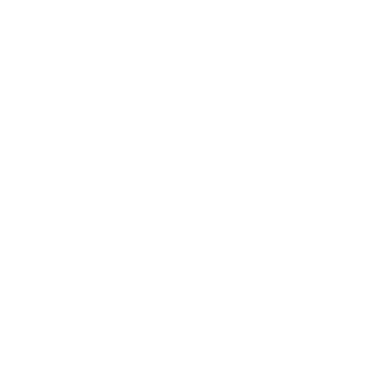

In [16]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

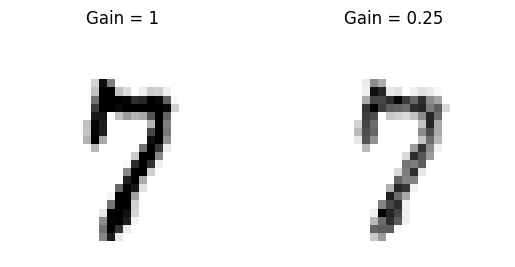

In [17]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

## 📊 Vẽ biểu đồ raster cho một ảnh đầu vào

Ngoài việc tạo animation, ta cũng có thể trực quan hóa một ảnh đã được mã hóa spike dưới dạng **biểu đồ raster**.

---

### 🧱 Yêu cầu:

Cần **reshape** ảnh đầu vào thành tensor 2 chiều dạng:



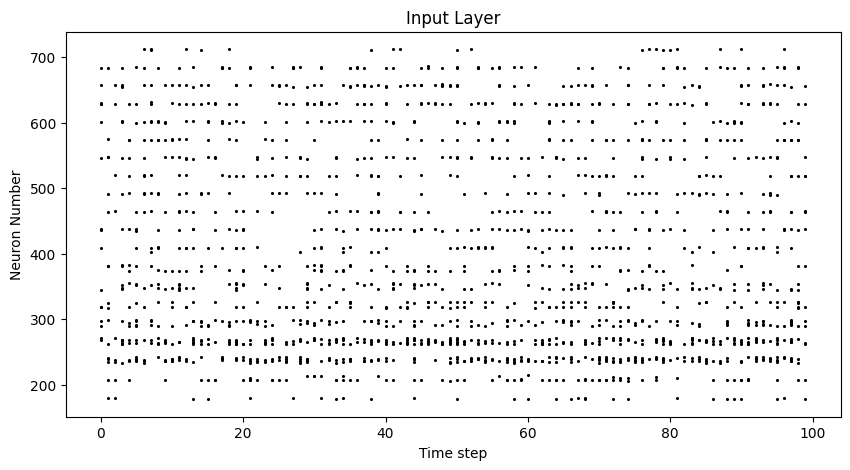

In [18]:
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

## 🔍 Kiểm tra hoạt động của một neuron cụ thể

Ta có thể **truy xuất một neuron đơn lẻ** để quan sát xem nó có phát xung hay không trong chuỗi thời gian.
## 🧠 Mỗi ảnh MNIST tương ứng với 784 neuron đầu vào

- Ảnh MNIST có kích thước **28 × 28 = 784 pixel**.
- Khi ta **mã hóa ảnh thành xung (spike)** qua `spikegen.rate(...)`, mỗi **pixel sẽ tương ứng với 1 neuron đầu vào**.
- Do đó, **mỗi ảnh sẽ được chuyển thành 784 chuỗi bit**, mỗi chuỗi có độ dài là `num_steps`.

---

### ✅ Giải thích ví dụ:

```python
idx = 210
spike_data_sample.reshape(num_steps, -1)[:, idx]


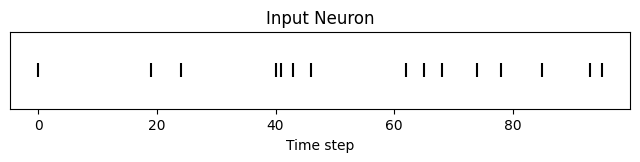

In [19]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## 🧠 2.2.3 Tóm tắt về Mã hóa theo Tần số (Rate Coding)

### 🎯 Rate Coding là gì?

- Rate coding là cách mã hóa mà **số lần phát xung (spike)** trong một khoảng thời gian thể hiện **giá trị của tín hiệu**.
- Trong SNN, đây là phương pháp phổ biến để chuyển đổi dữ liệu tĩnh (như ảnh MNIST) thành chuỗi xung thời gian.

---

### ⚠️ Một số tranh cãi xung quanh rate coding

1. **Tiêu thụ năng lượng**:
   - Mỗi lần phát xung tiêu tốn năng lượng.
   - Tự nhiên tối ưu hóa để tiết kiệm — nếu cần quá nhiều xung để thể hiện thông tin thì không hiệu quả.
   - Theo Olshausen & Field, rate coding chỉ có thể giải thích tối đa **15% hoạt động của vùng V1 (thị giác sơ cấp)** trong não.

2. **Thời gian phản ứng**:
   - Con người phản ứng trung bình sau ~250ms.
   - Nếu neuron bắn với tần số 10Hz, thì chỉ có thể phát được ~2 xung trong thời gian đó → quá chậm nếu chỉ dùng rate coding.

---

### ✅ Vậy tại sao vẫn dùng rate coding?

- Dù **không tối ưu về tốc độ hay năng lượng**, rate coding lại:
  - **Rất bền vững với nhiễu**: mất vài xung không ảnh hưởng nhiều vì có nhiều xung khác hỗ trợ.
  - **Dễ học hơn trong huấn luyện mạng nơ-ron**: theo nguyên lý Hebb — *"neurons that fire together, wire together"*, càng nhiều xung → càng dễ học.

---

### 📌 Kết luận:

- **Rate coding không phải là cơ chế duy nhất** trong não bộ.
- Nó có thể **kết hợp với các cơ chế khác** như latency coding, delta modulation,...
- Trong `snntorch`, `spikegen.rate(...)` là hàm thực hiện mã hóa kiểu này.



## 🕒 2.3 Mã hóa theo Độ trễ (Latency Coding) với MNIST

### 💡 Ý tưởng chính

- **Latency coding** là dạng mã hóa theo *thời điểm phát xung*, không phải số lần như trong rate coding.
- Mỗi pixel **chỉ được phát một xung duy nhất**, tại **thời điểm phụ thuộc vào độ sáng**:
  - Pixel **sáng hơn (giá trị gần 1)** sẽ phát xung **sớm hơn**
  - Pixel **tối hơn (giá trị gần 0)** sẽ phát xung **trễ hơn**

---

### ⚙️ Mô hình hoá: Điện áp RC

- Một đầu vào được coi là dòng điện bơm vào mạch RC → nạp điện cho tụ → nếu điện thế đạt ngưỡng thì phát xung.
![RC model](p_rc_model.png)

In [20]:
def convert_to_time(data, tau=5, threshold = 0.01):
    spike_time = tau * torch.log(data / (data - threshold))

    return spike_time

Now, use the above function to visualize the relationship between input feature intensity and its corresponding spike time.

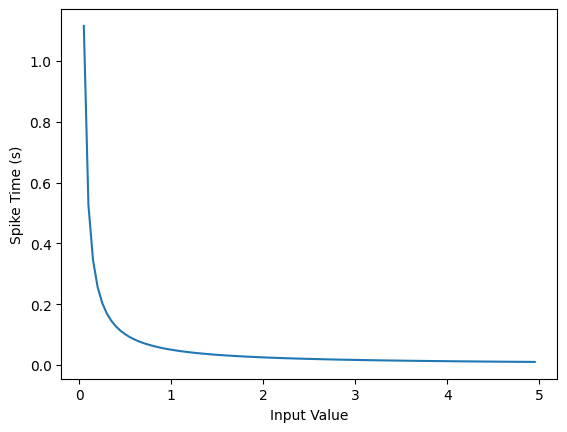

In [21]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

Giá trị nhỏ → thời gian phát trễ hơn (đồ thị có dạng log).

chuyển đổi về biểu diễn nhị phân (1/0)
spike_times chỉ chứa thời điểm phát xung, không phải tensor nhị phân.

Để mô phỏng SNN, cần chuyển đổi về tensor nhị phân (1: có xung, 0: không có).

Dùng hàm spikegen.latency để tự động thực hiện:

In [22]:
from snntorch import spikegen

spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

tau: hằng số thời gian của mạch RC (tăng → phát chậm hơn).

threshold: ngưỡng điện thế để phát xung.

Nếu giá trị đầu vào < ngưỡng → không phát được → gán vào bước thời gian cuối cùng.

# 2.3.1 Raster plot

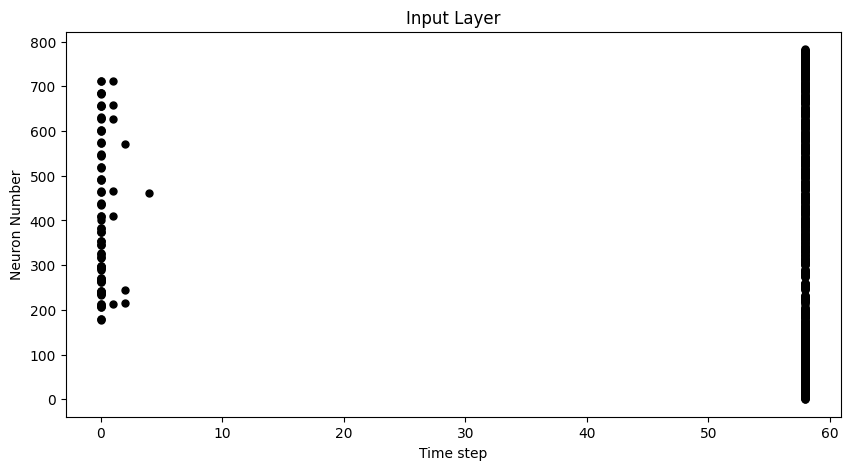

In [23]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()


To make sense of the raster plot, note that high intensity features fire first, whereas low intensity features fire last:
![Latency Coding](p_latency_coding.png)

### 📊 Phân bố thời gian phát xung không đều

Trong latency coding, do đặc tính **hàm logarit** và dữ liệu ảnh MNIST **thiếu các giá trị trung gian (xám/midtone)**, nên thời gian phát xung của các neuron thường bị **dồn cụm về hai phía**:

- 🔆 Pixel sáng → phát xung ngay từ đầu (thời gian ngắn).
- 🌑 Pixel tối → phát xung ở cuối thời gian (thời gian dài).

Điều này khiến biểu đồ thời gian phát xung có hai cụm rõ rệt.

---

### 🛠️ Cách cải thiện

- 📉 **Tăng giá trị `tau`** để làm chậm toàn bộ thời gian phát xung.
- 📈 **Làm tuyến tính hóa thời gian phát xung** bằng cách sử dụng tham số `linear=True` khi gọi `spikegen.latency`.

```python
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)


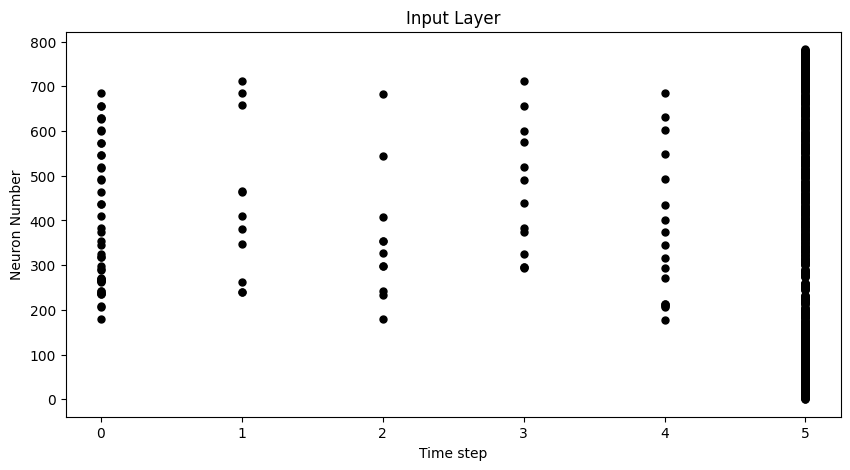

In [24]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

### 🔄 Phân bố thời gian phát xung đều hơn

Sau khi **làm tuyến tính hàm logarit**, ta thu được **phân bố thời gian phát xung đồng đều hơn** giữa các neuron đầu vào.

Việc này giúp khắc phục hiện tượng các neuron chỉ phát xung ở đầu hoặc cuối chuỗi thời gian, nhờ đó mô hình có thể khai thác tốt hơn các đặc trưng thời gian.

---

### 🧮 Mô hình tuyến tính

Khác với mô hình RC trước đó (mô phỏng mạch điện thật), **mô hình tuyến tính không dựa trên cơ sở vật lý**, mà chỉ đơn giản là một cách dễ hiểu và dễ triển khai hơn để mã hóa thời gian phát xung.

Mặc dù đơn giản, nhưng mô hình này rất hữu ích trong trường hợp dữ liệu đầu vào không đa dạng về mức xám (grayscale), như MNIST.

![Latency coding 01](p_latency_coding_01.png)


Quan sát thấy rằng **toàn bộ các xung phát ra chỉ nằm trong ~5 bước thời gian đầu**, trong khi **mô phỏng chạy đến 100 bước**. Điều này cho thấy phần lớn các bước thời gian còn lại là **dư thừa và không đóng góp gì** vào xử lý.

---

### 🛠️ Cách khắc phục

Có hai cách để giải quyết tình trạng này:

1. **Tăng giá trị `tau`**: Làm chậm thời gian phát xung bằng cách tăng hằng số thời gian của mạch RC.
2. **Dùng `normalize=True`**: Chuẩn hóa thời gian phát xung để trải đều toàn bộ trong phạm vi `num_steps`.


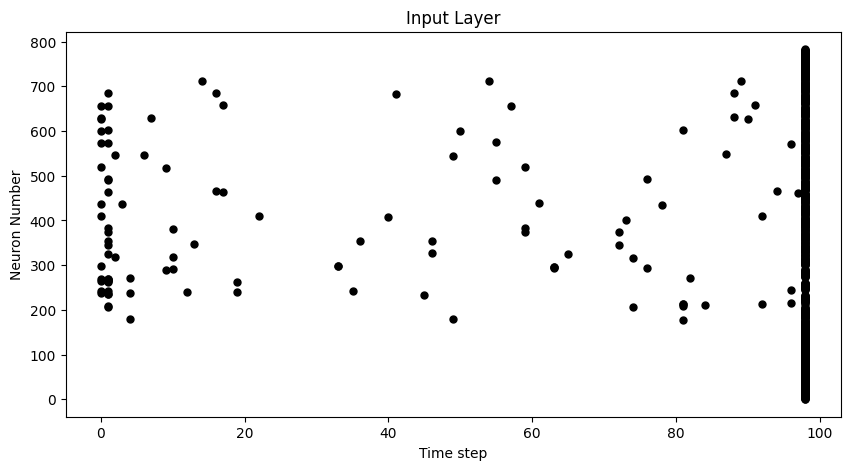

In [26]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, normalize=True, linear=True)
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()



### ⚡️ Ưu điểm của Latency Coding: Độ thưa (Sparsity)

Một ưu điểm lớn của **latency coding** so với **rate coding** là khả năng tạo ra **mã hóa thưa**. Khi mỗi neuron **chỉ được phép phát xung tối đa một lần** trong suốt chuỗi thời gian, điều này giúp giảm thiểu tiêu thụ năng lượng — rất quan trọng trong các hệ thống SNN.

---

### 🧠 Tối ưu thêm: Loại bỏ đặc trưng dư thừa

Ở ví dụ trước, phần lớn các xung xảy ra **ở bước thời gian cuối cùng**, tức là các giá trị đầu vào **nằm dưới ngưỡng kích hoạt (`threshold`)**. Những pixel tối (nền đen trong ảnh MNIST) này **không mang nhiều thông tin hữu ích**.

➡️ Ta có thể **loại bỏ các đặc trưng không kích hoạt** bằng cách dùng tham số `clip=True`:


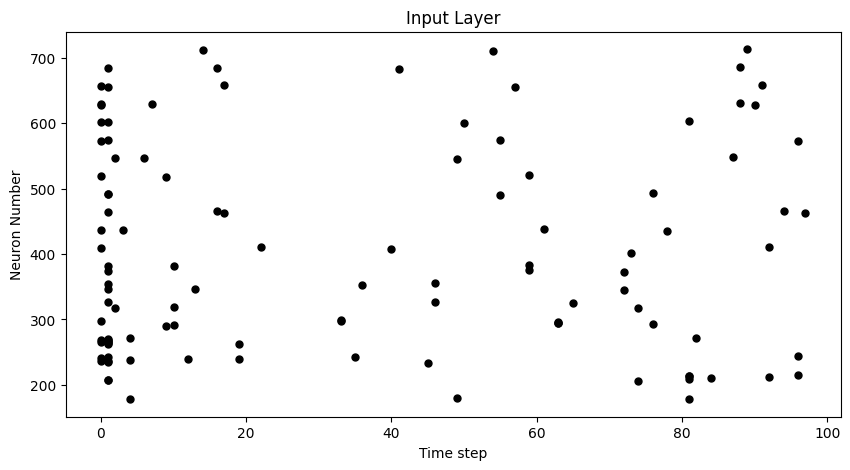

In [27]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)


fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

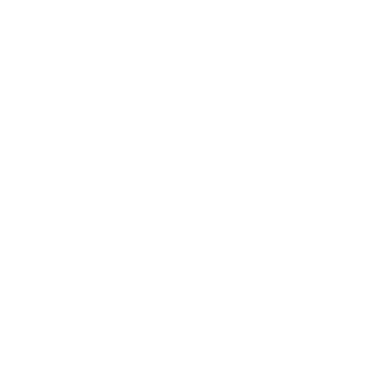

In [30]:
spike_data_sample = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

## 🔁 2.4 Mã hóa Delta (Delta Modulation)

Có nhiều giả thuyết cho rằng **võng mạc (retina)** của con người mang tính **thích ứng cao**: nó chỉ xử lý thông tin khi có sự thay đổi đáng kể. Nếu không có thay đổi trong trường nhìn, các tế bào cảm quang **ít có khả năng phát xung**.

> 🧠 Nói cách khác: sinh học hoạt động theo sự kiện (event-driven). Neuron phản ứng với **sự thay đổi**, chứ không phải trạng thái tĩnh.

---

### 📷 Cảm biến thị giác động (Dynamic Vision Sensor)

Một số nhà nghiên cứu đã thiết kế các cảm biến hình ảnh lấy cảm hứng từ võng mạc, chẳng hạn như **Dynamic Vision Sensor (DVS)**. Các cảm biến này **chỉ ghi nhận các thay đổi** trong cảnh, giúp tiết kiệm tài nguyên và tăng hiệu năng.

---

### ⚙️ Delta Modulation trong SNNTorch

Hàm `snntorch.spikegen.delta` mô phỏng hành vi này. Nó nhận đầu vào là một tensor theo thời gian (time-series), và **tính hiệu giữa các bước thời gian liên tiếp**. 

Nếu chênh lệch là **dương** và **lớn hơn một ngưỡng (`threshold`)**, một spike sẽ được sinh ra:

![Delta Modulation Illustration](p_delta_modulation.png)




<function matplotlib.pyplot.show(close=None, block=None)>

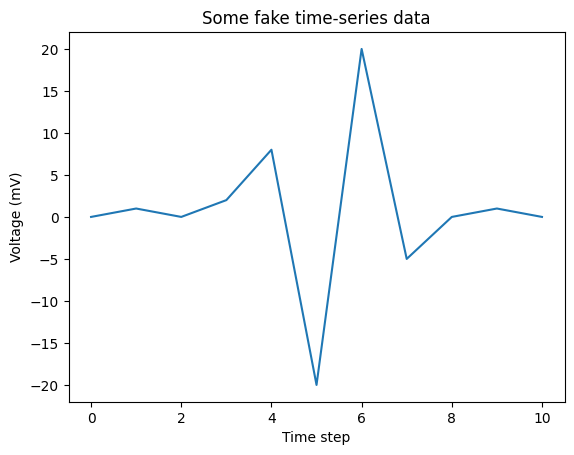

In [31]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show

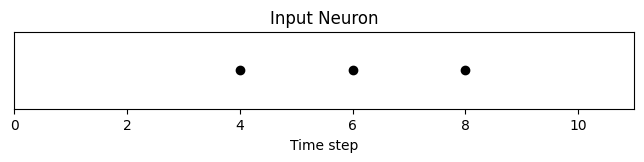

In [32]:
# convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

The large dip to -20 has not been captured in our spikes. It might be that we care about negative swings as well, in which case we can enable the optional argument off_spike=True.

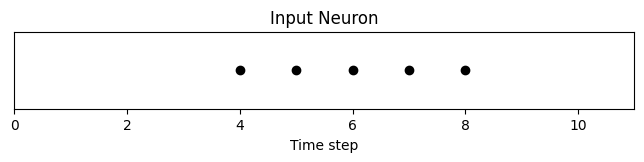

In [33]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

In [34]:
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


# 📌 Tổng kết các phương pháp mã hóa spike trong SNN (Spike Encoding)

## 🔁 Hai cách xử lý ảnh đầu vào (ví dụ ảnh MNIST)
1. **Trải đều ảnh tĩnh theo thời gian**:
   - Mỗi time step đều thấy cùng một ảnh.
   - Đơn giản nhưng không tận dụng được tính chất thời gian (temporal).

2. **Chuyển pixel thành chuỗi spike theo thời gian**:
   - Mỗi pixel tạo ra một chuỗi spike khác nhau theo time step.
   - Tận dụng tính động của mạng nơ-ron spiking.

---

## 🔧 Các phương pháp mã hóa

### ⚡ 1. Rate Coding
- **Ý tưởng**: Pixel càng sáng thì càng dễ phát spike ở mỗi time step.
- **Cách hoạt động**: Giống Bernoulli trial với xác suất tỉ lệ thuận với độ sáng.
- **Ưu điểm**:
  - Chịu nhiễu tốt (nhiều spike → mất vài cái không ảnh hưởng nhiều).
  - Dễ trực quan hóa.
- **Tham số**:
  - `gain`: giảm tần suất spike giữa các time step.
- **Mô hình spike**:
  - Nhiều spike có thể xảy ra.
  - Dữ liệu được flatten thành vector 1D (28×28 = 784 neuron).

---

### ⏱ 2. Latency Coding
- **Ý tưởng**: Mỗi pixel chỉ phát **một spike duy nhất**, thời điểm phát phụ thuộc vào độ sáng.
  - Sáng → phát sớm.
  - Tối → phát muộn hoặc không phát.
- **Ưu điểm**:
  - Spike **cực kỳ thưa thớt** → tiết kiệm năng lượng.
- **Vấn đề**:
  - **Clustering spike** ở đầu/cuối time step.
- **Tham số hỗ trợ**:
  - `linear=True`: trải đều thời gian spike (thay vì log).
  - `normalize=True`: phân bố đều spike trong toàn bộ `num_steps`.
  - `clip=True`: loại bỏ spike không có thông tin (pixel tối dưới `threshold`).

---

### 🔼 3. Delta Modulation (Event-driven Encoding)
- **Ý tưởng**: Chỉ phát spike khi **có sự thay đổi** theo thời gian.
  - Mô phỏng hoạt động của võng mạc sinh học.
- **Ưu điểm**:
  - Rất tiết kiệm tài nguyên.
  - Phát hiện tốt các thay đổi.
- **Tham số hỗ trợ**:
  - `threshold`: ngưỡng thay đổi để phát spike.
  - `off_spike=True`: phát spike khi giá trị giảm (bắt được cả tăng và giảm).

---

## 📊 Bảng so sánh nhanh

| Phương pháp     | Ưu điểm chính                              | Hạn chế chính                         |
|-----------------|--------------------------------------------|---------------------------------------|
| Rate coding     | Dễ huấn luyện, chịu nhiễu tốt              | Tốn năng lượng, không tận dụng thời gian |
| Latency coding  | Tiết kiệm năng lượng, mã hóa tinh tế       | Dễ phân cụm spike, cần điều chỉnh     |
| Delta modulation| Theo hướng "event-driven", siêu tiết kiệm  | Cần dữ liệu có biến động              |

---

## ✅ Ghi nhớ nhanh
- **Rate** → "Càng sáng càng nhiều spike"
- **Latency** → "Càng sáng càng phát sớm"
- **Delta** → "Chỉ phát khi thay đổi xảy ra"

